In [1]:
%matplotlib widget

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

1-D Gaussians at each row centered on the line

In [3]:
nI = [20,100]
dI = np.array([nI[1]/nI[0], 1.0])
I = np.zeros(nI)
sigma = 1
theta = np.pi/3
if theta < np.pi/4:
    t = np.linspace(start=0, stop=(nI[0]-1), num=nI[0])
    step = np.array([dI[0], dI[0]*np.tan(theta)]) # the line steps one pixel at a time in the driving direction
    line = t[:,None]*step
    for i in range(nI[0]):
        I[:,i] = np.exp(-0.5 * (np.arange(nI[1])*dI[1] - line[i,1])**2) / np.sqrt(2*np.pi*sigma/dI[1])
else:
    t = np.linspace(start=0, stop=(nI[1]-1), num=nI[1])
    step = np.array([dI[1]/np.tan(theta), dI[1]])
    line = t[:,None]*step
    for i in range(nI[1]):
        I[:,i] = np.exp(-0.5 * ((np.arange(nI[0])*dI[0] - line[i,0]) / sigma)**2) / np.sqrt(2*np.pi*(sigma/dI[0]))

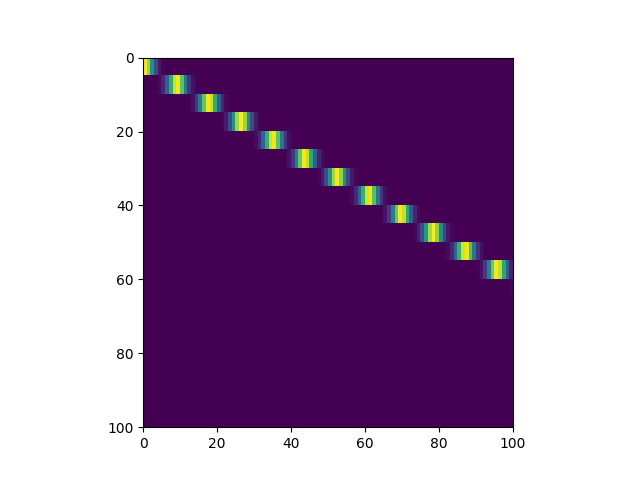

In [5]:
plt.figure()
plt.imshow(I, extent=(0,nI[1],nI[1],0))

2-D Gaussian centered on the line

In [18]:
nI = [8,128]
dI = np.array([nI[1]/nI[0], 1.0])
xI = [np.arange(n)*d for n,d in zip(nI,dI)]
XI = np.stack(np.meshgrid(*xI, indexing='ij'), axis=-1)

The vector projecting each point, $b$, in the image to the line $a$ with unit vector $\hat{a}$ is $b - \frac{\hat{a}\hat{a}^T}{\hat{a}^T\hat{a}}b$

In [19]:
theta = np.pi/3
a = np.array([[np.cos(theta)], [np.sin(theta)]])
P = a@a.T/(a.T@a) # projection matrix
dist = np.abs(XI[...,None] - (P[None,None]@XI[...,None]))

In [22]:
I = np.array(nI)
sigma = 1
sigma_inv = np.array([[dI[0]/sigma, 0],
                  [0, dI[1]/sigma]])
sigma_det = sigma**2 / (dI[0]*dI[1])
# sigma_inv = np.array([[1/sigma, 0], [0,1/sigma]])
# sigma_det = sigma**2
I = np.exp(-0.5 * (dist.transpose(0,1,3,2) @ sigma_inv @ dist)).squeeze() / (2*np.pi * np.sqrt(sigma_det)) # multivariate normal distribution

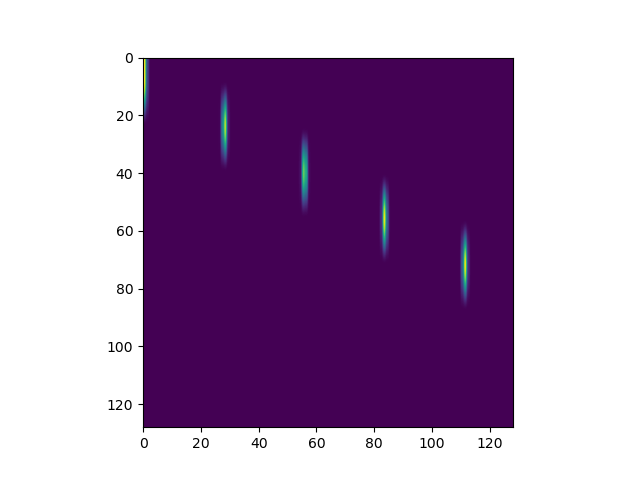

In [23]:
plt.figure()
plt.imshow(I, extent=(0,nI[1],nI[1],0))

Daniel's Method: 2D gaussians centered at sample points on the line.

In [20]:
nI = [20,100]
dI = np.array([nI[1]/nI[0], 1.0])
xI = [np.arange(n)*d for n,d in zip(nI,dI)]
XI = np.stack(np.meshgrid(*xI, indexing='ij'), axis=-1)
I = np.zeros(nI)
sigma = 1.0
# sigma_inv = np.array([[dI[0]/sigma, 0],
#                   [0, dI[1]/sigma]])
# sigma_det = sigma**2 / (dI[0]*dI[1])

# distances are measured in units not pixels so sigma does not have to be converted
sigma_inv = np.array([[1/sigma, 0],[0, 1/sigma]])
sigma_det = sigma**2
theta = np.pi/3
if theta < np.pi/4:
    print('less than 45')
    t = np.linspace(start=0, stop=(nI[0]-1), num=nI[0])
    step = np.array([dI[0], dI[0]*np.tan(theta)]) # the line steps one pixel at a time in the driving direction
    line = t[:,None]*step
    for i in range(nI[0]):
        dist = (XI - line[i])[...,None]
        I += np.exp(-0.5 * (dist.transpose(0,1,3,2) @ sigma_inv @ dist)**2).squeeze() / (2*np.pi * np.sqrt(sigma_det)) # multivariate normal distribution
else:
    print('greater or equal to 45')
    t = np.linspace(start=0, stop=(nI[1]-1), num=nI[1])
    step = np.array([dI[1]/np.tan(theta), dI[1]])
    line = t[:,None]*step
    for i in range(nI[1]):
        dist = (XI - line[i])[...,None]
        I += np.exp(-0.5 * (dist.transpose(0,1,3,2) @ sigma_inv @ dist)**2).squeeze() / (2*np.pi * np.sqrt(sigma_det))        

less than 45


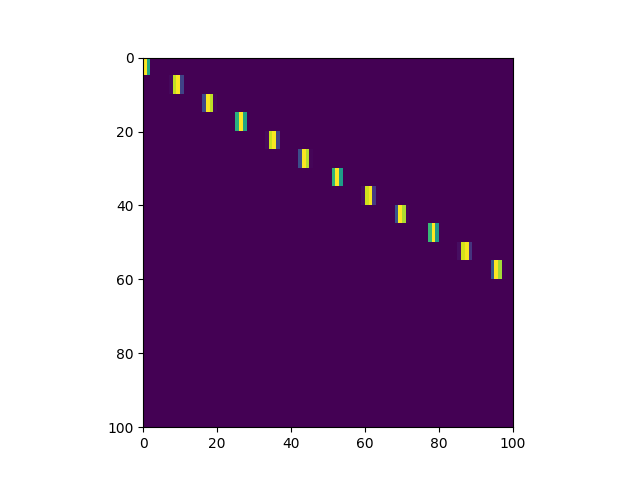

In [21]:
plt.figure()
plt.imshow(I, extent=(0,nI[1],nI[1],0))

# Draw parallel lines using mod 

In [5]:
from scipy.linalg import expm

In [3]:
# put it all together
def make_line(x,a,b,Sigma,period=None):
    # domain
    d = np.array([xi[1] - xi[0] for xi in x])
    n = np.array([len(xi) for xi in x])
    X = np.stack(np.meshgrid(*x,indexing='ij'),-1)
    
    # rotation matrix
    axis = -np.cross(np.array([1.0,0.0,0.0]),a)
    angle = np.arccos(np.dot(a,np.array([1.0,0.0,0.0])))    
    K = np.array([[0.0,-axis[2],axis[1]],
             [axis[2],0.0,-axis[0]],
             [-axis[1],axis[0],0.0]])
    R = expm(angle*K)
    # covariance
    Sigma_ = R@Sigma@R.T
    Sigma__ = Sigma_[1:,1:]
    # I THINK this is the covariance of the elipse when sliced in the new z=const slice plane
    Sigma___ = R[1:,1:].T@Sigma__@R[1:,1:]
    
    # draw
    Z = 1.0/np.sqrt(2.0*np.pi**2)/np.linalg.det(Sigma__)**0.5
    # note this is a 2D gaussian function
    x_ = (R@(X-b)[...,None])
    # note that the 0the component will not go into the gaussian
    x__ = x_[...,1:,:]
    # now
    if period is not None:
        #x__ = ((x__-period/2)%period) + period/2
        x__ = ((x__+period/2)%period) - period/2
        
    tmp = np.linalg.inv(Sigma__)@x__    
    tmp = x__.swapaxes(-1,-2)@tmp

    return Z*np.exp(-0.5*tmp[...,0,0])

In [6]:
a = np.array([1.0,1.0,1.0])
a /= np.sqrt(np.sum(a**2))
b = np.array([0.0,0.0,0.0])
Sigma = np.array([1.0,1.0,1.0]),
n = np.array([72,72,72])
d = np.array([1.0,1.0,1.0])
x = [np.arange(ni)*di for ni,di in zip(n,d)]
I = make_line(x,a,b,Sigma,period=15)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 3)